In [3]:
import pandas as pd
import numpy as np

flow_data = pd.read_csv("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/flows.csv")

# Add noise to the flow numbers
noise = np.random.normal(loc=0, scale=0.1, size=flow_data['flow'].shape)
flow_data['flow'] = flow_data['flow'] * (1 + noise)

# Ensure no negative flow values
flow_data['flow'] = flow_data['flow'].clip(lower=0)

# Convert flow values to integers
flow_data['flow'] = flow_data['flow'].astype(int)

# Save the modified data to a new CSV file
flow_data.to_csv('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/generated-flow.csv', index=False)

print('Dummy data with noise has been saved to generated-flow.csv')

Dummy data with noise has been saved to generated-flow.csv


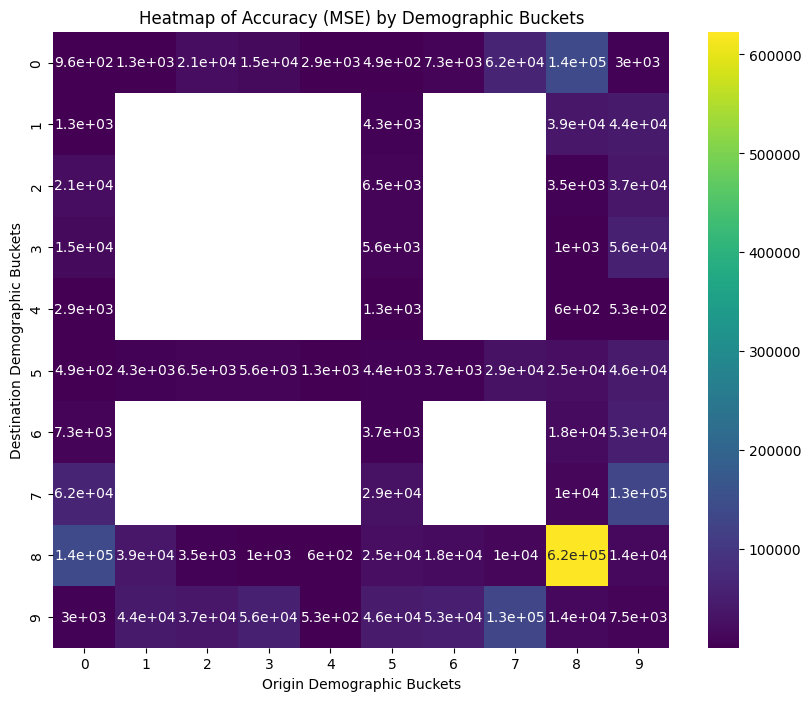

Fairness Metric (Variance of Accuracy): 721291729356.7418


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def evaluate_fairness(flows_path, generated_flows_path, features_path, demographic_column):
    # Load data
    flows = pd.read_csv(flows_path)
    generated_flows = pd.read_csv(generated_flows_path)
    features = pd.read_csv(features_path)
    
    # Create demographic buckets
    features['bucket'] = pd.qcut(features[demographic_column], q=10, labels=False)

    # Map geoids to buckets
    geoid_to_bucket = dict(zip(features['GEOID'], features['bucket']))

    # Assign flow pairs to buckets
    def get_bucket_pair(row):
        origin_bucket = geoid_to_bucket.get(row['origin'], -1)
        destination_bucket = geoid_to_bucket.get(row['destination'], -1)
        if origin_bucket > destination_bucket:
            origin_bucket, destination_bucket = destination_bucket, origin_bucket
        return origin_bucket, destination_bucket
    
    flows['bucket_pair'] = flows.apply(get_bucket_pair, axis=1)
    generated_flows['bucket_pair'] = generated_flows.apply(get_bucket_pair, axis=1)
    
    # Merge the flows on origin and destination to ensure correct pairing
    merged_flows = pd.merge(flows, generated_flows, on=['origin', 'destination'], suffixes=('_real', '_gen'))

    # Calculate accuracy for each bucket
    mse_per_bucket = {}
    
    for bucket_pair in flows['bucket_pair'].unique():
        if bucket_pair == (-1, -1):
            continue
        
        real_flows = merged_flows[merged_flows['bucket_pair_real'] == bucket_pair]['flow_real']
        gen_flows = merged_flows[merged_flows['bucket_pair_gen'] == bucket_pair]['flow_gen']
        
        if len(real_flows) > 0 and len(gen_flows) > 0:
            mse = mean_squared_error(real_flows, gen_flows)
            mse_per_bucket[bucket_pair] = mse
    
    # Create a 10x10 matrix of accuracy
    accuracy_matrix = np.full((10, 10), np.nan)
    
    for (i, j), mse in mse_per_bucket.items():
        accuracy_matrix[i, j] = mse
        accuracy_matrix[j, i] = mse

    # Define fairness as the variance of accuracy across buckets
    fairness = np.nanvar(list(mse_per_bucket.values()))

    # Plot heatmap of accuracy
    plt.figure(figsize=(10, 8))
    sns.heatmap(accuracy_matrix, annot=True, cmap='viridis', cbar=True, square=True)
    plt.title('Heatmap of Accuracy (MSE) by Demographic Buckets')
    plt.xlabel('Origin Demographic Buckets')
    plt.ylabel('Destination Demographic Buckets')
    plt.show()
    
    return fairness

# Example usage
flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/flows.csv'
generated_flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/generated-flows.csv'
features_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/features.csv'
demographic_column = 'RPL_THEME1'

fairness = evaluate_fairness(flows_path, generated_flows_path, features_path, demographic_column)
print(f'Fairness Metric (Variance of Accuracy): {fairness}')


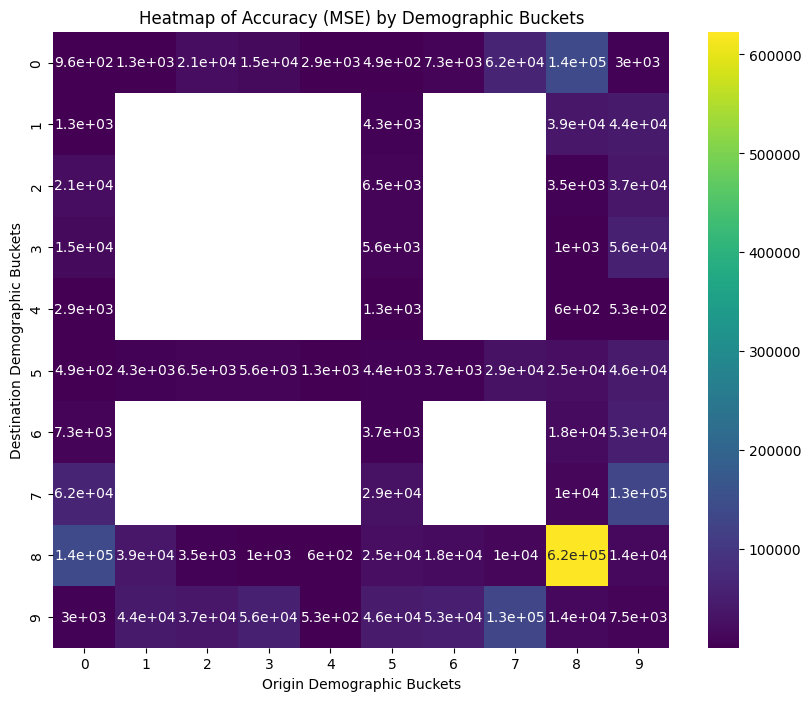

Fairness Metric (Variance of Accuracy): 721291729356.7418


In [8]:
flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/flows.csv'
generated_flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/generated-flows.csv'
features_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/features.csv'
demographic_column = 'RPL_THEME1'

# Load data
flows = pd.read_csv(flows_path)
generated_flows = pd.read_csv(generated_flows_path)
features = pd.read_csv(features_path)

# Create demographic buckets
features['bucket'] = pd.qcut(features[demographic_column], q=10, labels=False)

# Map geoids to buckets
geoid_to_bucket = dict(zip(features['GEOID'], features['bucket']))

# Assign flow pairs to buckets
def get_bucket_pair(row):
    origin_bucket = geoid_to_bucket.get(row['origin'], -1)
    destination_bucket = geoid_to_bucket.get(row['destination'], -1)
    if origin_bucket > destination_bucket:
        origin_bucket, destination_bucket = destination_bucket, origin_bucket
    return origin_bucket, destination_bucket

flows['bucket_pair'] = flows.apply(get_bucket_pair, axis=1)
generated_flows['bucket_pair'] = generated_flows.apply(get_bucket_pair, axis=1)

# Merge the flows on origin and destination to ensure correct pairing
merged_flows = pd.merge(flows, generated_flows, on=['origin', 'destination'], suffixes=('_real', '_gen'))

# Calculate accuracy for each bucket
mse_per_bucket = {}

for bucket_pair in flows['bucket_pair'].unique():
    if bucket_pair == (-1, -1):
        continue
    
    real_flows = merged_flows[merged_flows['bucket_pair_real'] == bucket_pair]['flow_real']
    gen_flows = merged_flows[merged_flows['bucket_pair_gen'] == bucket_pair]['flow_gen']
    
    if len(real_flows) > 0 and len(gen_flows) > 0:
        mse = mean_squared_error(real_flows, gen_flows)
        mse_per_bucket[bucket_pair] = mse

# Create a 10x10 matrix of accuracy
accuracy_matrix = np.full((10, 10), np.nan)

for (i, j), mse in mse_per_bucket.items():
    accuracy_matrix[i, j] = mse
    accuracy_matrix[j, i] = mse

# Define fairness as the variance of accuracy across buckets
fairness = np.nanvar(list(mse_per_bucket.values()))

# Plot heatmap of accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, annot=True, cmap='viridis', cbar=True, square=True)
plt.title('Heatmap of Accuracy (MSE) by Demographic Buckets')
plt.xlabel('Origin Demographic Buckets')
plt.ylabel('Destination Demographic Buckets')
plt.show()

print(f'Fairness Metric (Variance of Accuracy): {fairness}')


In [9]:
merged_flows

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/html.py", line 644, in render
    super().render()
  File "/Users/apoorvasheera/an

     Unnamed: 0_real  destination       origin  flow_real bucket_pair_real  \
0                  0  53033000100  53033000100      41647           (9, 9)   
1                  1  53033000100  53033000200       2629           (9, 9)   
2                  2  53033000100  53033000401        952           (8, 9)   
3                  3  53033000100  53033000402        417           (5, 9)   
4                  4  53033000100  53033000600        150           (8, 9)   
..               ...          ...          ...        ...              ...   
490              490  53033011800  53033000401        266          (-1, 8)   
491              491  53033011800  53033000402         67          (-1, 5)   
492              492  53033011900  53033000100         62          (-1, 9)   
493              493  53033011900  53033000401         77          (-1, 8)   
494              494  53033011900  53033000402         39          (-1, 5)   

     Unnamed: 0_gen  flow_gen bucket_pair_gen  
0              

In [10]:
features

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/html.py", line 644, in render
    super().render()
  File "/Users/apoorvasheera/an

    Unnamed: 0        GEOID  ACRES_TOTAL  Total_Households  RPL_THEME1  \
0            0  53033002500   243.219083              1245      0.1116   
1          584  53033002600   307.584420              1940      0.2419   
2         1361  53033003200   510.293459              4021      0.0471   
3         2277  53033003500   317.452448              1818      0.1123   
4         2844  53033003400   194.497752              1468      0.0970   
5         3317  53033003300   320.320495              3071      0.1240   
6         4212  53033002800   242.985396              2114      0.0243   
7         4839  53033002900   243.681675              1843      0.1310   
8         5489  53033003000   368.967447              2407      0.1823   
9         6473  53033003100   530.703146              2638      0.0534   
10        7302  53033001701   220.593456              1931      0.4033   
11        7927  53033001702   316.329146              1911      0.2287   
12        8639  53033001600   476.7483

In [11]:
flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/flows.csv'
generated_flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/generated-flows.csv'
features_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/features.csv'
demographic_column = 'RPL_THEME1'

# Load data
flows = pd.read_csv(flows_path)
generated_flows = pd.read_csv(generated_flows_path)
features = pd.read_csv(features_path)

# Extract GeoID from features
features_geoids = set(features['GEOID'])

# Check origin GeoIDs in flows
origin_geoids_flows = set(flows['origin'])
missing_origin_geoids = origin_geoids_flows - features_geoids
print(f'Number of missing origin GeoIDs in flows: {len(missing_origin_geoids)}')
print(f'Missing origin GeoIDs in flows: {missing_origin_geoids}')

# Check destination GeoIDs in flows
destination_geoids_flows = set(flows['destination'])
missing_destination_geoids = destination_geoids_flows - features_geoids
print(f'Number of missing destination GeoIDs in flows: {len(missing_destination_geoids)}')
print(f'Missing destination GeoIDs in flows: {missing_destination_geoids}')

# Check origin GeoIDs in generated flows
origin_geoids_generated_flows = set(generated_flows['origin'])
missing_origin_geoids_generated_flows = origin_geoids_generated_flows - features_geoids
print(f'Number of missing origin GeoIDs in generated flows: {len(missing_origin_geoids_generated_flows)}')
print(f'Missing origin GeoIDs in generated flows: {missing_origin_geoids_generated_flows}')

# Check destination GeoIDs in generated flows
destination_geoids_generated_flows = set(generated_flows['destination'])
missing_destination_geoids_generated_flows = destination_geoids_generated_flows - features_geoids
print(f'Number of missing destination GeoIDs in generated flows: {len(missing_destination_geoids_generated_flows)}')
print(f'Missing destination GeoIDs in generated flows: {missing_destination_geoids_generated_flows}')


Number of missing origin GeoIDs in flows: 0
Missing origin GeoIDs in flows: set()
Number of missing destination GeoIDs in flows: 77
Missing destination GeoIDs in flows: {53033011200, 53033006600, 53033010702, 53033006100, 53033010200, 53033005600, 53033009701, 53033009702, 53033005100, 53033009200, 53033004600, 53033008700, 53033008200, 53033007700, 53033011800, 53033007200, 53033011300, 53033006700, 53033010800, 53033006200, 53033010300, 53033005700, 53033009800, 53033005200, 53033009300, 53033004700, 53033008800, 53033008300, 53033007800, 53033011900, 53033011402, 53033006800, 53033010900, 53033006300, 53033010401, 53033010402, 53033005801, 53033005802, 53033009900, 53033005301, 53033005302, 53033009400, 53033004800, 53033008900, 53033008400, 53033007900, 53033007401, 53033006900, 53033011001, 53033006400, 53033010500, 53033005900, 53033010001, 53033005400, 53033009500, 53033004900, 53033009000, 53033004400, 53033008001, 53033007500, 53033011600, 53033007000, 53033011101, 53033011102

In [ ]:
!cd 

In [14]:
!pwd

/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


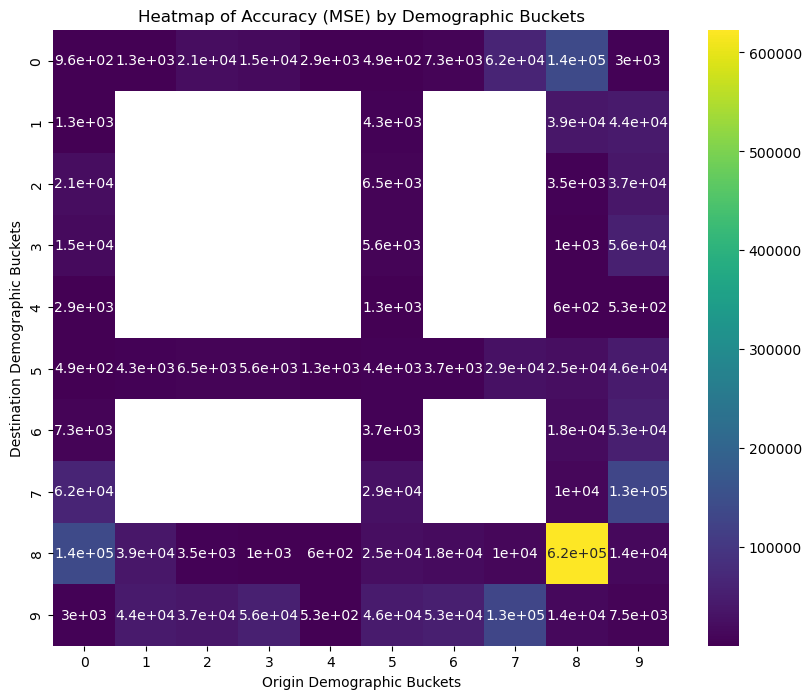

Fairness Metric (Variance of Accuracy): 721291729356.7418


In [1]:
from eval import FlowEvaluator

flows_path = 'dummy-data/flows.csv'
generated_flows_path = 'dummy-data/generated-flows.csv'
features_path = 'dummy-data/features.csv'
demographic_column = 'RPL_THEME1'

evaluator = FlowEvaluator(flows_path, generated_flows_path, features_path)
fairness = evaluator.evaluate_fairness(accuracy_metric='mean_squared_error', variance_metric='np.nanvar', demographic_column=demographic_column)
print(f'Fairness Metric (Variance of Accuracy): {fairness}')

